In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np
from scipy.special import beta as BETA

In [2]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

torch.autograd.set_detect_anomaly(True)
plt.set_cmap("gray")

<Figure size 432x288 with 0 Axes>

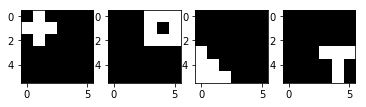

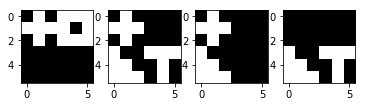

In [3]:
# Synthetic Data Genration

'''Basis Generation'''
k1 = np.zeros((6,6))
k1[0:3,1] = 1.0
k1[1,0:3] = 1.0

k2 = np.zeros((6,6))
k2[0:3,-3:] = 1.0
k2[1,-2] = 0

k3 = np.zeros((6,6))
k3[-3:,0:3] = 1.0
k3[-3:-1,2] = 0.0
k3[-3,1:2] = 0.0

k4 = np.zeros((6,6))
k4[-3:,-2] = 1.0
k4[-3,-3:] = 1.0

fig, ax = plt.subplots(1,4)

ax[0].imshow(k1)
ax[1].imshow(k2)
ax[2].imshow(k3)
ax[3].imshow(k4)


'''Data Generation'''

train_size = 3000
test_size = 500

train_weights = np.random.rand(train_size, 4)>0.5
train_data = np.dot(train_weights,np.array([k1.reshape(-1,1),k2.reshape(-1,1),k3.reshape(-1,1),k4.reshape(-1,1)]).reshape(4,-1))
train_data += np.random.normal(0,0.1)

test_weights = np.random.rand(test_size, 4)>0.5
test_data = np.dot(test_weights,np.array([k1.reshape(-1,1),k2.reshape(-1,1),k3.reshape(-1,1),k4.reshape(-1,1)]).reshape(4,-1))
test_data += np.random.normal(0,0.1)


fig, ax = plt.subplots(1,4)

ax[0].imshow(train_data[0].reshape(6,6))
ax[1].imshow(train_data[300].reshape(6,6))
ax[2].imshow(test_data[0].reshape(6,6))
ax[3].imshow(test_data[300].reshape(6,6))

In [4]:
BATCH_SIZE = 100

trainloader = torch.utils.data.DataLoader(train_data.reshape(-1,1,6,6), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


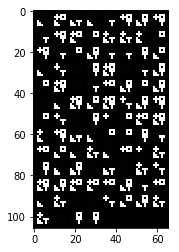

In [5]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images = dataiter.next()
show_images(images)

In [6]:
class GLM_NP(nn.Module):
    def __init__(self, latent_variable_dim, alpha = 1.0, rholr = 10e-12):
        super(GLM_NP, self).__init__()
        
        ### Global Params
        self.eps1 = torch.tensor(10e-6).float()
        self.eps2 = torch.tensor(10e-4).float()
        
        # V : Stick breaking : Beta {kumaraswamy}
        self.aeys = nn.Parameter(torch.rand(1,latent_variable_dim)*0.1 + alpha)
        self.bees = nn.Parameter(torch.rand(1,latent_variable_dim)*0.1 + 1.0)
        self.unif_sampler = torch.distributions.uniform.Uniform(self.eps1, 1-self.eps1)
        
        # IBP prior
        self.alpha = alpha
        self.euler_constant = -torch.digamma(torch.tensor(1.0))
        
        # Z : Bernoulli
        self.phi = nn.Parameter(torch.randn((36 + 1),latent_variable_dim))
        
        # Gumbel Softmax params
        self.temperature = 10
        self.t_prior = 1.0 # prior lambda
        
        self.gumbel_sampler = torch.distributions.gumbel.Gumbel(0,1)
        
        # Basis
        self.A = nn.Parameter(torch.randn(latent_variable_dim, 36))
        
        ### Russian Roulette part
        self.rhos = torch.zeros(latent_variable_dim + 1,1) + 0.5
        self.rholr = rholr
        
        ## Optimizer
        self.optimizer = None
        self.K = latent_variable_dim
        self.max_K = latent_variable_dim
        
    
    def reparameterize_gumbel_kumaraswamy(self, inter_z, p):
        '''Proper Sampling is required with masking'''
        
        N, K = inter_z.shape
        sample_size = 10
        
        U = self.unif_sampler.sample([N,K,sample_size])
        G1 = self.unif_sampler.sample([N,K,sample_size])
        logit_G1 = G1.log() - (1-G1).log() 
        
        V = (1-(U+self.eps1).pow(1/self.aeys.exp()[:,:K].view(-1,K,1)) + self.eps1 ).pow(1/self.bees.exp()[:,:K].view(-1,K,1))
        
        pi = torch.zeros_like(V)+1
        for i in range(K):
            for j in range(i+1):
                pi[:,i,:] *= V[:,j,:]
        
        rand_num = torch.rand_like(pi)
        rand_logit = (rand_num/(1-rand_num)).log()
        
        
        logit_pi = ((pi + self.eps1)/(1-pi + self.eps1)).log()
        alpha = (logit_pi + inter_z.view(N,K,1)).sigmoid()
        logit_alpha = (alpha + self.eps1)/(1-alpha + self.eps1)
        
        z1 = (logit_alpha + logit_G1)/self.temperature
        
        pz1 = (logit_pi + logit_G1)/self.temperature
        
        y = z1.sigmoid()
        
        py = pz1.sigmoid()
        
        
        return y, alpha, pi, py
        
    def forward(self, input, k):
        x = input.view(-1, 36)
        N, D = x.shape
        
        if(k == 0):
            k = self.get_current_K()
            
        
        inter_z = self.phi # 785 x K
        x_cat = torch.cat((input.view(N,36), torch.ones(N).view(N,-1)), 1).view(N,36+1) # N x 785
        inter_z = torch.mm(x_cat, inter_z[:,:k]) # N x K
        
        z, gi, pi, py = self.reparameterize_gumbel_kumaraswamy(inter_z, k) # N x K
        
        x = self.decode(z.mean(dim=-1).view(N,k), k)
        
        return x, z, gi, pi, py

    
    def decode(self, z, k):
        
        x = F.linear(z, self.A.transpose(0,1)[:,:k])
        
        return x
    
    
    def add_k_node(self, k):
        # Add k latent features ...
        if(k == 0):
            return 
        with torch.no_grad():
            self.aeys = nn.Parameter(torch.cat((self.aeys, torch.rand(1,k)*0.1 + self.alpha), 1))
            self.bees = nn.Parameter(torch.cat((self.bees, torch.rand(1,k)*0.1 + 1.0), 1))
            
            self.phi = nn.Parameter(torch.cat((self.phi, torch.randn((36 + 1),k)), 1))
            self.A = nn.Parameter(torch.cat((self.A, torch.randn(k, 36)), 0))
            
            
            self.rhos = torch.cat((self.rhos, torch.zeros(k,1) + 0.5), 0)
    
    def del_k_node(self, k):
        # Retain k Latent Features ...
        if(k == 0 or k == self.get_current_K()):
            return
        with torch.no_grad():
            c_K = self.get_current_K()
            
            self.aeys = nn.Parameter(list(torch.split(self.aeys, c_K - k , 1))[0])
            self.bees = nn.Parameter(list(torch.split(self.bees, c_K - k , 1))[0])
            
            self.phi = nn.Parameter(list(torch.split(self.phi, c_K - k , 1))[0])
            self.A = nn.Parameter(list(torch.split(self.A, c_K - k , 0))[0])
            
            self.rhos = list(torch.split(self.rhos, c_K - k + 1, 0))[0]
                             
    def get_current_K(self):
        return self.K
    
    def constraint_proj(self):
        with torch.no_grad():
#             self.aeys[self.aeys < 0.001] = 0.001
#             self.bees[self.bees < 0.001] = 0.001
#             self.rhos[self.rhos < 10e-6] = 10e-6
#             self.rhos[self.rhos > 1 - 10e-6] = 1 - 10e-6
            pass

In [17]:
def retain_k_nodes(model , new_K = 0):
    
    current_K = model.get_current_K()
    if(current_K < new_K):
        model.add_k_node(new_K - current_K)
    elif(current_K > new_K):
        model.del_k_node(current_K - new_K)
    else:
        pass
    
    model.K = new_K
    optimizer = torch.optim.Adam(model.parameters(), 0.01)
    
    return optimizer

In [18]:
def rrs_loss(model, images, rhos, fixed = False):
    
    
    curr_K = model.K
    one_minus_rho = (1 - rhos[0:curr_K+1]).view(curr_K+1,1)
    weight = torch.zeros_like(one_minus_rho)
    weight[curr_K] = one_minus_rho[curr_K]
    for i in range(1,curr_K+1):
        weight[curr_K-i] = weight[curr_K-i+1] + one_minus_rho[curr_K - i]
        
    weight = weight[1:]
    
    N = images.shape[0]
    global_multiplier = (N/3000)*1000
    _, z, gi, pi, py = model(images, 0)
    
    softplus = nn.Softplus()
    eps = model.eps1
        
        
        
    KL_kuma = ((model.aeys.exp() - model.alpha)/(model.aeys.exp()))*(-model.euler_constant -torch.digamma(model.bees.exp()) - 1/model.bees.exp())
    KL_kuma += (model.aeys.exp().log() + model.bees.exp().log()) + torch.log(torch.tensor(BETA(model.alpha,1)))
    KL_kuma -= (model.bees.exp() - 1)/(model.bees.exp()) 
    KL_kuma = (KL_kuma*global_multiplier).view(1,-1)
    KL_kuma_w = (KL_kuma[:,:curr_K]*weight.view(1,-1)).sum()
    
    
    logit_pi = (pi+eps).log() - (1-pi+eps).log()
    logit_x  =  (z+eps).log() - (1 -z+eps).log()
    logit_gi = (gi+eps).log() - (1-gi+eps).log()

    tau = model.temperature
    tau_prior = model.t_prior
    exp_term_p = logit_pi - logit_x*(tau)
    exp_term_q = logit_gi - logit_x*(tau_prior)
    log_tau = torch.log(torch.tensor(model.temperature, requires_grad = False))
    log_pz = log_tau + exp_term_p - 2.0*softplus(exp_term_p)
    log_qz = log_tau + exp_term_q - 2.0*softplus(exp_term_q)
    
    qz = log_qz.exp()
    KL_gumb = qz*(log_qz - log_pz)#/qz.sum(dim=-1).view(N,curr_K,-1)
    
    
#     KL_gumb = z*((z+eps).log() + 0.30102999566)
    
    
    
    KL_gumb[KL_gumb != KL_gumb] = 0
#     KL_gumb[KL_gumb < 0] = 0
    KL_gumb = KL_gumb.mean(dim =-1).mean(dim = 0).view(1,-1)#.abs()
    KL_gumb_w = (KL_gumb*weight.view(1,-1)).sum()
    
    
    
    l = torch.zeros(curr_K+1,1)
    lik_loss = 0
    for i in range(1,curr_K+1):
        
        recon_image = model.decode(z[:,:i,:].mean(dim=-1).view(N,i), i)
        Lik = -0.5*(recon_image - images.view(-1,36)).pow(2)
        Lik = torch.sum(Lik)/N - float(36*0.5*np.log(2*np.pi))
        
        lik_loss += Lik*one_minus_rho[i]
        
        l[i,:] = - Lik + KL_gumb[:,:i].sum() + KL_kuma[:,:i].sum()
        
    
    
    
    l_final = - lik_loss + KL_gumb_w + KL_kuma_w
    print(lik_loss/one_minus_rho.sum() , KL_gumb_w , KL_kuma_w)
    
    
    if(not fixed):
        return l, one_minus_rho, l_final
    else:
        return l, one_minus_rho, l[-1,:].sum()

In [49]:
def train_step(model, images, sample_max = 5, sample = False, keep_graph = False):
    
    """ sample a trucation level and then do the same"""
    
    curr_K = model.get_current_K()
    model.rhos[0] = 0.9999
    model.optimizer = retain_k_nodes(model , new_K = model.max_K+1)
    model.optimizer = retain_k_nodes(model , new_K = model.max_K)
    
    rhos = list(model.rhos)
    L = len(rhos)
    samples = []
    
    for i in range(sample_max):

        k = 1
        
        while(True):
            u = np.random.uniform()
            if(u > rhos[k]):
                samples.append(k)
                break
            k += 1

            if(k > L-1 and sample):
                rhos.append(0.5)
                L = len(rhos)
            elif(k > L-1):
                break
                
    
                
    samples.sort()
    if(sample):
        curr_K = model.get_current_K()
        new_value = int(np.mean(samples[-7:]))
        
        if(new_value > model.max_K):
            model.optimizer = retain_k_nodes(model , new_K = new_value)
            model.K = new_value
            model.max_K = new_value
        else:
            model.optimizer = retain_k_nodes(model , new_K = model.max_K)
            model.K = new_value
            
    else:
        new_value = curr_K
        
        
    
    
    omrho = 1 - np.array(rhos)[:model.K+1]
    weight = omrho*0
    for i in range(len(samples)):
        val = samples[i]+1
        weight[:val] += omrho[:val]
    
    weight/=len(samples)
    weight = torch.tensor(weight).view(1,-1).float()
    
    

    print("Current Truncated Level :", new_value)
    print(model.rhos)
    model.optimizer.zero_grad()
    curr_K = model.get_current_K()
    
    l ,one_minus_rho, l_final_params = rrs_loss(model, images, weight[:,:curr_K+1], False)
#     l_final_params = (l*one_minus_rho).sum()
    
    
    if(l_final_params != l_final_params):
        pass
    else:
        try:
            l_final_params.backward()
            model.optimizer.step()
        except:
            print("failed")

    model.constraint_proj()
    
    
    
    ws = torch.zeros(curr_K+1, curr_K)
    for k in range(2,curr_K+2):
        for i in range(k-1,curr_K+1):
            if(i < k-1):
                ws[k-1,i-1] = 0
            elif(i == k-1):
                ws[k-1,i-1] = 1/(model.rhos[k-1] - 1)
            else:
                ws[k-1,i-1] = 1/model.rhos[k-1]
            
#     print(ws)
#     assert 1 == 2
    rho_grads = (torch.mm(ws,(l*one_minus_rho)[1:,:]))
    rho_grads[rho_grads != rho_grads] = 0.0
    rho_logit = ((model.rhos).log() - (1 - model.rhos).log())[:curr_K+1]
    sig_rho = rho_logit.sigmoid()
    
    rho_logit[:curr_K+1,:] = rho_logit[:curr_K+1,:] + model.rholr*(sig_rho*(1-sig_rho)*rho_grads.view(-1,1))
    model.rhos[:curr_K+1,:] = rho_logit.sigmoid()
    
    return l_final_params

In [50]:
glm = GLM_NP(1,4,10e-5)

In [51]:
## train
train_loss = []
glm.temperature = 1.0
keep_graph = True

Epoch no : 100 batch_no : 29 curr_loss : 1.1520929718017578


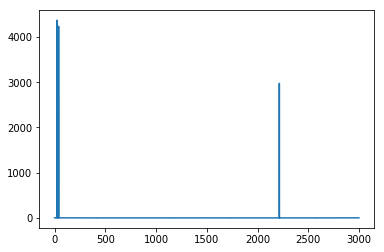

In [52]:
# optimizer = torch.optim.Adam(glm.parameters(), 0.1)
for epoch in range(100):
    
        
    for i, data in enumerate(trainloader, 0):
        images = data.float()
        images = images.to(device)
            
        if(i%5 == 0 and True):
            l = train_step(glm, images, 10, True, keep_graph)
        else:
            l = train_step(glm, images, 10, False, keep_graph)
            
        
        
        train_loss.append((l/((1 - glm.rhos[:glm.K]).sum())).item() / len(images))

        glm.temperature /= 1.1
        if(glm.temperature < .01):
            glm.temperature = 0.01
        

#         optimizer.zero_grad()
#         l = get_kth_trunc_loss(glm, images, K = 0)
#         try:
#             l.backward()
#         except:
#             pass
#         train_loss.append(l.item())
#         optimizer.step()
    
        

        if(i%1 == 0):
            clr(wait = True)
            print("Epoch no :", epoch + 1, "batch_no :", i, "curr_loss :",  train_loss[-1])
        
plt.plot(train_loss)
plt.show()

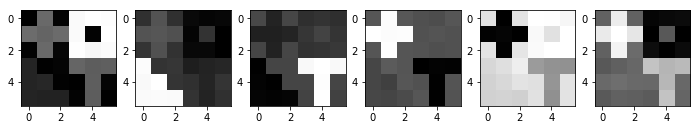

In [53]:
K = max(glm.get_current_K(),2)
fig, ax = plt.subplots(1,K, figsize = [2*K,6])
for i in range(K):
    ax[i].imshow((glm.A[i]).view(6,6).detach(), cmap= 'gray')
plt.savefig('sample.png')
plt.show()

In [24]:
glm.temperature

0.01

In [25]:
glm.aeys.exp()

tensor([[4.0233, 3.9732, 4.0093, 3.9869, 4.0378, 4.0132, 4.0735, 4.0504]],
       grad_fn=<ExpBackward>)

In [26]:
glm.bees.exp()

tensor([[1.0106, 0.9939, 1.0061, 1.0039, 0.9968, 1.0032, 1.0083, 1.0244]],
       grad_fn=<ExpBackward>)

In [27]:
glm.rhos.log() - (1-glm.rhos).log()

tensor([[ 9.2101],
        [ 1.8345],
        [ 1.6890],
        [ 1.4969],
        [ 1.2707],
        [ 0.9721],
        [ 0.6003],
        [-0.0437],
        [-1.6836]], grad_fn=<SubBackward0>)

In [28]:
train_data.max()

1.0088614615929088

In [29]:
glm.max_K

8

In [30]:
glm.K

8

In [32]:
recon_image, z, gi, pi, _ = glm(images, K)

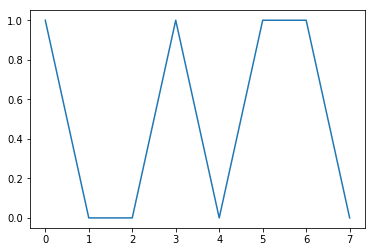

In [36]:
plt.plot(z[0,:,0].detach().numpy())

In [43]:
gi[10,:,0]

tensor([9.8983e-20, 6.8134e-05, 7.1704e-04, 9.9253e-01, 9.3720e-01, 7.0875e-04,
        7.6411e-01, 8.2365e-01], grad_fn=<SelectBackward>)

In [1401]:
def get_rho_prob(rhos):
    
    rho_np = rhos.detach().numpy().reshape(-1)
    mt = rho_np.copy()
    
    for i in range(1,mt.shape[0]):
        prod = 1
        for j in range(i):
            prod*=rhos[j]
    
        mt[i-1] = prod*(1-rhos[i])

    return mt

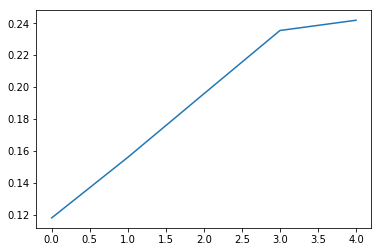

In [1402]:
plt.plot(get_rho_prob(glm.rhos)[:-1])

In [1403]:
glm.rhos

tensor([[0.9999],
        [0.8821],
        [0.8233],
        [0.7305],
        [0.5562],
        [0.1803]], grad_fn=<CopySlices>)